The goal of this project was to explore 2019 California SBAC testing data from the [CA Dept of Education website.](https://caaspp-elpac.cde.ca.gov/caaspp/DashViewReport?ps=true&lstTestYear=2019&lstTestType=B&lstGroup=1&lstSubGroup=1&lstSchoolType=A&lstGrade=13&lstCounty=00&lstDistrict=00000&lstSchool=0000000). The main question I wanted to answer was whether students in CA who's parents have graduated high school have significantly higher math scores than students who's parents have not graduated from high school. 



In [19]:
import pandas as pd
import numpy as np
import seaborn as sns

In [20]:
cd ..

/Users/katybarone/Downloads


In [21]:
cd ~/Downloads/sb_ca2019_all_csv_v3


/Users/katybarone/Downloads/sb_ca2019_all_csv_v3


In [22]:
#Loading in two datasets from CAASPP Research files. 
df = pd.read_csv('sb_ca2019_all_csv_v3.txt', sep = ',')
entities = pd.read_csv('sb_ca2019entities_csv.txt', sep = ',', encoding = 'ISO-8859-1')

In [ ]:
df.head()

In [23]:
# Removing unnecessary columns
df = df.iloc[:,0:17].reset_index(drop = True)
entities = entities.drop(['Test Year', 'Filler'], axis = 1)

In [ ]:
df.dtypes, entities.dtypes

In [24]:
# Selecting the names of the columns from df that I want to make numeric
cols_to_numeric = ['CAASPP Reported Enrollment',
                   'Students Tested',
                   'Mean Scale Score',
                   'Percentage Standard Exceeded',
                   'Percentage Standard Met',
                   'Percentage Standard Met and Above']

In [25]:
# Looping through the list of column names to transform the type from object to numeric and coercing the errors.
for col in cols_to_numeric:
    df[col] = pd.to_numeric(df[col], errors = 'coerce')
print(df.dtypes)

County Code                            int64
District Code                          int64
School Code                            int64
Filler                               float64
Test Year                              int64
Subgroup ID                            int64
Test Type                             object
Total Tested At Entity Level          object
Total Tested with Scores              object
Grade                                  int64
Test Id                                int64
CAASPP Reported Enrollment           float64
Students Tested                      float64
Mean Scale Score                     float64
Percentage Standard Exceeded         float64
Percentage Standard Met              float64
Percentage Standard Met and Above    float64
dtype: object


This dataset includes the following general subgroups: the entire state of CA, each districts' average scores, and each county's average scores. I want to remove those subgroups so we aren't double counting schools. I also want to remove grade specific data. "Grade" == 13 is the subgroup for "All students".

In [27]:
grades_sep = df[df['Grade']!= 13]

In [28]:
df_sep_schools = df[(df['Grade']==13) & (df['County Code'] != 0) & (df['District Code']!=0) & (df['School Code'] != 0)].reset_index(drop = True)

In [ ]:
df_sep_schools.head(20)

In [29]:
# There are two different tests that make up this dataframe. "Test ID" == 2 is the SBAC Math test. "Test Id" == 1 is the SBAC ELA test.
math = df_sep_schools[df_sep_schools['Test Id']==2]
ela = df_sep_schools[df_sep_schools['Test Id'] ==1]
math.head()

,County Code,District Code,School Code,Filler,Test Year,Subgroup ID,Test Type,Total Tested At Entity Level,Total Tested with Scores,Grade,Test Id,CAASPP Reported Enrollment,Students Tested,Mean Scale Score,Percentage Standard Exceeded,Percentage Standard Met,Percentage Standard Met and Above
39,1,10017,112607,NaN,2019,1,B,84,84,13,2,90.0,84.0,NaN,3.57,7.14,10.71
40,1,10017,112607,NaN,2019,3,B,41,41,13,2,43.0,41.0,NaN,4.88,9.76,14.63
41,1,10017,112607,NaN,2019,4,B,43,43,13,2,47.0,43.0,NaN,2.33,4.65,6.98
42,1,10017,112607,NaN,2019,6,B,78,78,13,2,83.0,78.0,NaN,3.85,7.69,11.54
43,1,10017,112607,NaN,2019,7,B,*,*,13,2,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
# There should be about the same amount of data in each dataset. 

In [30]:
print((len(math),len(ela)))

(398816, 398815)


In [ ]:
# Merging our main dataset with the "entites" dataset. 
# This adds in school level data like school name, zip code and school type.

In [31]:
math = math.merge(entities, how = 'left', on = 'School Code')
ela = ela.merge(entities, how = 'left', on = 'School Code')

In [ ]:
print(math.columns)

In [32]:
from scipy.stats import ttest_ind
from matplotlib import pyplot as plt


math_hs_grad = math[math['Subgroup ID']== 91]
math_no_grad = math[math['Subgroup ID'] ==90]
math_hs_grad = math_hs_grad['Percentage Standard Met and Above']
math_no_grad = math_no_grad['Percentage Standard Met and Above']


math_grad_mean = np.mean(math_hs_grad)
math_no_grad_mean = np.mean(math_no_grad)
math_grad_std = np.std(math_hs_grad)
math_no_grad_std = np.std(math_no_grad)

print(math_no_grad_mean, math_grad_mean)

21.859467353951832 27.894322476379916


In [33]:
math_hs_grad2 = math_hs_grad.fillna(math_grad_mean)
math_no_grad2 = math_no_grad.fillna(math_no_grad_mean)


In [34]:
tstat, pval = ttest_ind(math_hs_grad2, math_no_grad2)
print(pval)

8.243457355917089e-235


In [36]:
print(math_hs_grad2.isna().sum())

0


/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:780: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:781: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


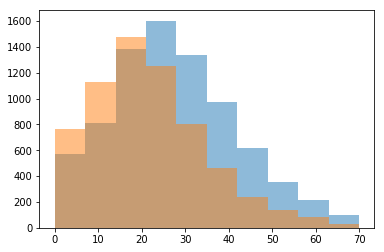

In [37]:
plt.hist(math_hs_grad, range = (0,70), alpha = 0.5)
plt.hist(math_no_grad, range = (0,70), alpha = 0.5)
plt.show()